In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
#Problem 1
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from ISLP import load_data

# load Auto dataset
Auto = load_data('Auto')
Auto = Auto.dropna()

# create polynomial terms for horsepower
Auto['hp2'] = Auto['horsepower']**2
Auto['hp3'] = Auto['horsepower']**3
Auto['hp4'] = Auto['horsepower']**4
Auto['hp5'] = Auto['horsepower']**5

# fit polynomial regression models of increasing degree
model1 = ols('mpg ~ horsepower', data=Auto).fit()
model2 = ols('mpg ~ horsepower + hp2', data=Auto).fit()
model3 = ols('mpg ~ horsepower + hp2 + hp3', data=Auto).fit()
model4 = ols('mpg ~ horsepower + hp2 + hp3 + hp4', data=Auto).fit()
model5 = ols('mpg ~ horsepower + hp2 + hp3 + hp4 + hp5', data=Auto).fit()

anova_results = anova_lm(model1, model2, model3, model4, model5)
print(anova_results)


   df_resid          ssr  df_diff      ss_diff           F        Pr(>F)
0     390.0  9385.915872      0.0          NaN         NaN           NaN
1     389.0  7442.029412      1.0  1943.886460  103.876722  8.878263e-22
2     388.0  7426.436007      1.0    15.593405    0.833275  3.618941e-01
3     387.0  7399.522632      1.0    26.913375    1.438187  2.311666e-01
4     386.0  7223.371686      1.0   176.150946    9.413092  2.306429e-03


The comparison between the cubic (degree 3) and quartic (degree 4) models gives F = 1.44 and p = 0.23, indicating that the quartic term is not significant.

Therefore, the quadratic (degree 2) model is the highest polynomial degree statistically justified.

Although the fifth-degree term is significant, it likely represents overfitting rather than meaningful improvement.

In [ ]:
#Problem 2
import numpy as np
import pandas as pd
import statsmodels.api as sm
from ISLP import load_data
from patsy import dmatrix

# load Boston dataset
Boston = load_data('Boston')
Boston = Boston.dropna()

# create B-spline basis for lstat with specified knots and degree
# degree 3 B-spline with knots at 10, 20, and 30
transformed_x = dmatrix(
    "bs(lstat, knots=(10,20,30), degree=3, include_intercept=True)",
    data=Boston,
    return_type='dataframe'
)

# print the shape of the transformed design matrix
print(transformed_x.shape)

# create and fit the linear model
model = sm.OLS(Boston['medv'], transformed_x).fit()

print(model.summary())


(506, 8)
                            OLS Regression Results                            
Dep. Variable:                   medv   R-squared:                       0.683
Model:                            OLS   Adj. R-squared:                  0.680
Method:                 Least Squares   F-statistic:                     179.6
Date:                Fri, 17 Oct 2025   Prob (F-statistic):          3.29e-121
Time:                        12:06:34   Log-Likelihood:                -1549.2
No. Observations:                 506   AIC:                             3112.
Df Residuals:                     499   BIC:                             3142.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                                                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------

Using the Boston dataset, a regression spline model was fitted to predict `medv`
using `lstat` with cubic B-splines (internal knots at 10, 20, and 30). 

The B-spline transformation created **8 basis functions**, and the fitted model
achieved an **R-squared of 0.683**, indicating that the model explains about 68.3%
of the variation in median home value. 

While multicollinearity warnings appear due to overlapping spline basis functions,
this is expected in spline models and does not indicate a model error.


R-squared: 0.27128624861547346


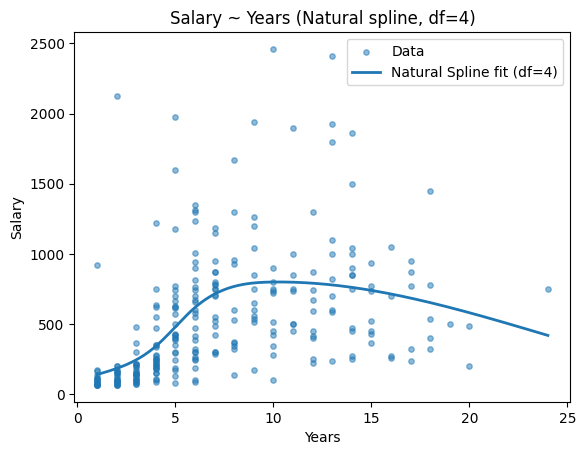

Design matrix shape: (263, 5)


In [ ]:
#Problem 3
import numpy as np
import pandas as pd
import statsmodels.api as sm
from ISLP import load_data
from ISLP.models import ModelSpec as MS, ns

# load Hitters dataset
Hitters = load_data('Hitters').dropna()

# define response and natural spline basis for Years with 4 degrees of freedom
y = Hitters['Salary']
ns_years = MS([ns('Years', df=4)]).fit(Hitters)   
Xns = ns_years.transform(Hitters)           

# fit the model
model = sm.OLS(y, Xns).fit()
print("R-squared:", model.rsquared)

# scatter plot with natural spline fit
xs = np.linspace(Hitters['Years'].min(), Hitters['Years'].max(), 200)
grid = pd.DataFrame({'Years': xs})
X_line = ns_years.transform(grid)
pred = model.predict(X_line)

import matplotlib.pyplot as plt
plt.scatter(Hitters['Years'], Hitters['Salary'], s=15, alpha=0.5, label='Data')
plt.plot(xs, pred, linewidth=2, label='Natural Spline fit (df=4)')
plt.xlabel('Years'); plt.ylabel('Salary'); plt.title('Salary ~ Years (Natural spline, df=4)')
plt.legend(); plt.show()

print("Design matrix shape:", Xns.shape)  # (n_rows, n_columns)




Using the Hitters dataset, we fitted a natural spline regression model 
to predict `Salary` based on `Years`, with 4 degrees of freedom.

The model achieved an R-squared of **0.27**, indicating that `Years` explains 
approximately 27% of the variation in salary. The design matrix generated 
by the natural spline basis contained **5 columns**, corresponding to the 
intercept and 4 spline basis functions.

The fitted curve shows that salary increases rapidly during the early years 
of a player's career, peaks around 5–10 years of experience, and then declines 
slightly thereafter, suggesting a nonlinear but interpretable relationship 
between experience and earnings.


Training R-squared: 0.5142227904413001


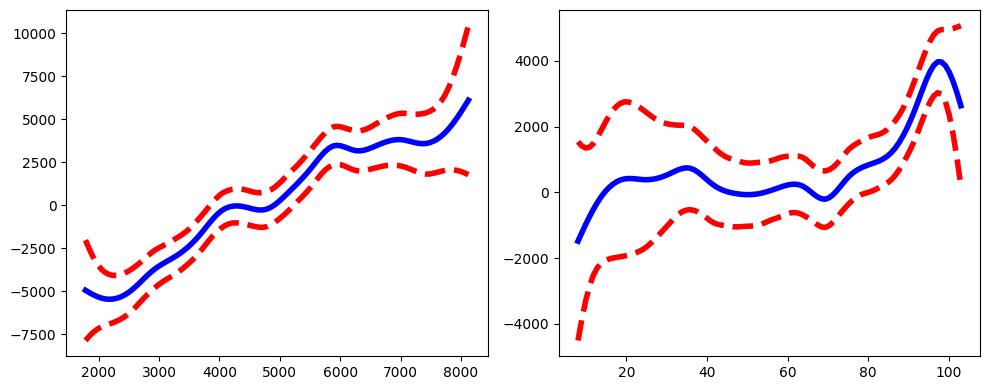

In [ ]:
#problem 4
import numpy as np
import pandas as pd
import statsmodels.api as sm
from ISLP import load_data
from pygam import LinearGAM, s as s_gam
from ISLP.pygam import plot as plot_gam
import matplotlib.pyplot as plt

# load College dataset
College = load_data('College')
College = College.dropna()

# define response and predictors
y = College['Outstate']
X = College[['Room.Board', 'PhD']]

# create and fit the GAM model
gam = LinearGAM(s_gam(0) + s_gam(1)).fit(X, y)

# train R-squared
r2 = gam.score(X, y)
print("Training R-squared:", r2)

# Partial Dependence Plots
fig, axs = plt.subplots(1, 2, figsize=(10,4))
# room and board
plot_gam(gam, 0, ax=axs[0])  
# PhD
plot_gam(gam, 1, ax=axs[1]) 
plt.tight_layout()
plt.show()



Using the College dataset, we fitted a Generalized Additive Model (GAM) 
to predict `Outstate` tuition using smoothing spline terms for `Room.Board` 
and `PhD`.

 The fitted model achieved a training R-squared of **0.51**, 
indicating that the model explains about 51% of the variation in tuition. 

The partial dependence plots reveal that `Outstate` tuition increases 
steadily with `Room.Board`, while `PhD` has a positive but nonlinear effect, 
rising until approximately 90% and then leveling off. 

These results suggest that schools with higher room and board costs 
and a larger proportion of PhD faculty tend to charge higher out-of-state 
tuition, though the relationship is not purely linear.


In [12]:
#Problem 5
import pandas as pd
import statsmodels.api as sm
from ISLP import load_data

# load Carseats dataset
Carseats = load_data('Carseats').dropna()

# split Price into 4 bins and create dummy variables
Carseats['Price_bin'] = pd.cut(Carseats['Price'], bins=4)
dummies = pd.get_dummies(Carseats['Price_bin'], drop_first=True).astype(float)

# OLS
X = sm.add_constant(dummies, has_constant='add')
y = Carseats['Sales'].astype(float)
model = sm.OLS(y, X).fit()

# model summary
print("R-squared:", model.rsquared)
print(model.params)

# identify bin with strongest negative effect
coef_bins = model.params.drop('const')
worst_bin = coef_bins.idxmin()
print("Strongest negative effect bin:", worst_bin, "coef =", coef_bins.min())


R-squared: 0.14784094987050878
const              10.960000
(65.75, 107.5]     -2.301295
(107.5, 149.25]    -4.006532
(149.25, 191.0]    -5.504375
dtype: float64
Strongest negative effect bin: (149.25, 191.0] coef = -5.504374999999994


Using the Carseats dataset, we created a step function model to predict `Sales` based on `Price` divided into four bins. 

The fitted model achieved an R-squared of **0.148**, indicating that price category explains about 15% of 
the variation in sales.

The coefficients become more negative as price increases, with the highest price bin (149.25–191.0) showing the strongest 
negative effect (−5.50). 

This suggests that stores with higher prices tend to have substantially lower average sales.
